# 0.Import Libraries

In [1]:
     
import pandas as pd
import numpy as np
# for visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# feature engineering
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.ensemble import StackingClassifier, RandomForestClassifier

# for xgboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# for other model types
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# for evaluating metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from mlxtend.plotting import plot_confusion_matrix

# 1.Load Dataset

In [3]:
dataset = pd.read_excel(r'Data/Date_Fruit_Datasets.xlsx')

# 3.Analyze Dataset

In [4]:
dataset.shape

(898, 35)

In [5]:
dataset.head()

,AREA,PERIMETER,MAJOR_AXIS,MINOR_AXIS,ECCENTRICITY,EQDIASQ,SOLIDITY,CONVEX_AREA,EXTENT,ASPECT_RATIO,...,KurtosisRR,KurtosisRG,KurtosisRB,EntropyRR,EntropyRG,EntropyRB,ALLdaub4RR,ALLdaub4RG,ALLdaub4RB,Class
0,422163,2378.908,837.8484,645.6693,0.6373,733.1539,0.9947,424428,0.7831,1.2976,...,3.2370,2.9574,4.2287,-59191263232,-50714214400,-39922372608,58.7255,54.9554,47.8400,BERHI
1,338136,2085.144,723.8198,595.2073,0.5690,656.1464,0.9974,339014,0.7795,1.2161,...,2.6228,2.6350,3.1704,-34233065472,-37462601728,-31477794816,50.0259,52.8168,47.8315,BERHI
2,526843,2647.394,940.7379,715.3638,0.6494,819.0222,0.9962,528876,0.7657,1.3150,...,3.7516,3.8611,4.7192,-93948354560,-74738221056,-60311207936,65.4772,59.2860,51.9378,BERHI
3,416063,2351.210,827.9804,645.2988,0.6266,727.8378,0.9948,418255,0.7759,1.2831,...,5.0401,8.6136,8.2618,-32074307584,-32060925952,-29575010304,43.3900,44.1259,41.1882,BERHI
4,347562,2160.354,763.9877,582.8359,0.6465,665.2291,0.9908,350797,0.7569,1.3108,...,2.7016,2.9761,4.4146,-39980974080,-35980042240,-25593278464,52.7743,50.9080,42.6666,BERHI


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 898 entries, 0 to 897
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   AREA           898 non-null    int64  
 1   PERIMETER      898 non-null    float64
 2   MAJOR_AXIS     898 non-null    float64
 3   MINOR_AXIS     898 non-null    float64
 4   ECCENTRICITY   898 non-null    float64
 5   EQDIASQ        898 non-null    float64
 6   SOLIDITY       898 non-null    float64
 7   CONVEX_AREA    898 non-null    int64  
 8   EXTENT         898 non-null    float64
 9   ASPECT_RATIO   898 non-null    float64
 10  ROUNDNESS      898 non-null    float64
 11  COMPACTNESS    898 non-null    float64
 12  SHAPEFACTOR_1  898 non-null    float64
 13  SHAPEFACTOR_2  898 non-null    float64
 14  SHAPEFACTOR_3  898 non-null    float64
 15  SHAPEFACTOR_4  898 non-null    float64
 16  MeanRR         898 non-null    float64
 17  MeanRG         898 non-null    float64
 18  MeanRB    

In [7]:
dataset['Class'].value_counts()

DOKOL     204
SAFAVI    199
ROTANA    166
DEGLET     98
SOGAY      94
IRAQI      72
BERHI      65
Name: Class, dtype: int64

In [8]:
dataset.isnull().sum().sum()

0

# 4.Visualize Data

# 5.Train Test Split

In [9]:
features=dataset.drop('Class',axis=1)
labels=pd.DataFrame(dataset['Class'],columns=['Class'])
X_train, X_test, Y_train, Y_test=train_test_split(features,labels,test_size=0.2,shuffle=True,stratify=labels)

# 6.Column Transformer

In [10]:
column_names=X_train.columns
num_columns_trans=Pipeline(steps=[('scale',StandardScaler())])
col_transformer=ColumnTransformer(transformers=[('num',Pipeline(steps=[('scale',StandardScaler())]),column_names)])

# 7.Class Weights

In [11]:
class_count=Y_train['Class'].value_counts().to_dict()
for key, value in class_count.items():
    # do something with value
    class_count[key] = round(value/len(Y_train),8)
class_count

{'DOKOL': 0.2270195,
 'SAFAVI': 0.22144847,
 'ROTANA': 0.18523677,
 'DEGLET': 0.1086351,
 'SOGAY': 0.10445682,
 'IRAQI': 0.08077994,
 'BERHI': 0.0724234}

In [12]:
sum(class_count.values())

1.0

# 8.LGBMClassifier
## 8.1 Pipeline

In [13]:
pipeline_lgbm=Pipeline(steps=[
    ('transformer',col_transformer),
    ('model',LGBMClassifier(boosting_type='gbdt',
                            num_leaves=200,
                            max_depth=-1,
                            learning_rate=0.095,
                            n_estimators=200,
                            subsample_for_bin=200000,
                            objective=None,
                            class_weight=class_count,
                            min_split_gain=0.0,
                            min_child_weight=0.001,
                            min_child_samples=20,
                            subsample=1.0,
                            subsample_freq=0,
                            colsample_bytree=1.0,
                            reg_alpha=0.0,
                            reg_lambda=0.0,
                            random_state=None))
])

## 8.2 Grid Search

In [14]:
param_grid_lgbm = {
    'model__num_leaves':[199,120],
    'model__learning_rate':[0.095,0.1],
    'model__n_estimators':[220,200]
}

grid_search_lgbm = GridSearchCV(pipeline_lgbm, param_grid_lgbm, cv=5, scoring='accuracy',error_score='raise')
# and now we train over all the possible combinations of the parameters above
grid_search_lgbm.fit(X_train,Y_train.values.ravel())

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scale',
                                                                                          StandardScaler())]),
                                                                         Index(['AREA', 'PERIMETER', 'MAJOR_AXIS', 'MINOR_AXIS', 'ECCENTRICITY',
       'EQDIASQ', 'SOLIDITY', 'CONVEX_AREA', 'EXTENT', 'ASPECT_RATIO',
       'ROUNDNESS', 'COMPACTNESS', 'SHAPEFACTOR_1', 'SHAPEFACTOR_2',
       'SH...
                                       ('model',
                                        LGBMClassifier(class_weight={'BERHI': 0.0724234,
                                                                     'DEGLET': 0.1086351,
                                                                     'DOKOL': 0.2270195,

In [15]:
grid_preds_lgbm=grid_search_lgbm.predict(X_test)

## 8.3 Model Evaluation

In [16]:
grid_search_lgbm.best_params_

{'model__learning_rate': 0.1,
 'model__n_estimators': 220,
 'model__num_leaves': 199}

In [17]:
print(classification_report(Y_test,grid_preds_lgbm))

              precision    recall  f1-score   support

       BERHI       1.00      0.62      0.76        13
      DEGLET       0.75      0.60      0.67        20
       DOKOL       0.93      1.00      0.96        41
       IRAQI       0.78      1.00      0.88        14
      ROTANA       0.91      0.97      0.94        33
      SAFAVI       1.00      1.00      1.00        40
       SOGAY       0.74      0.74      0.74        19

    accuracy                           0.89       180
   macro avg       0.87      0.85      0.85       180
weighted avg       0.90      0.89      0.89       180



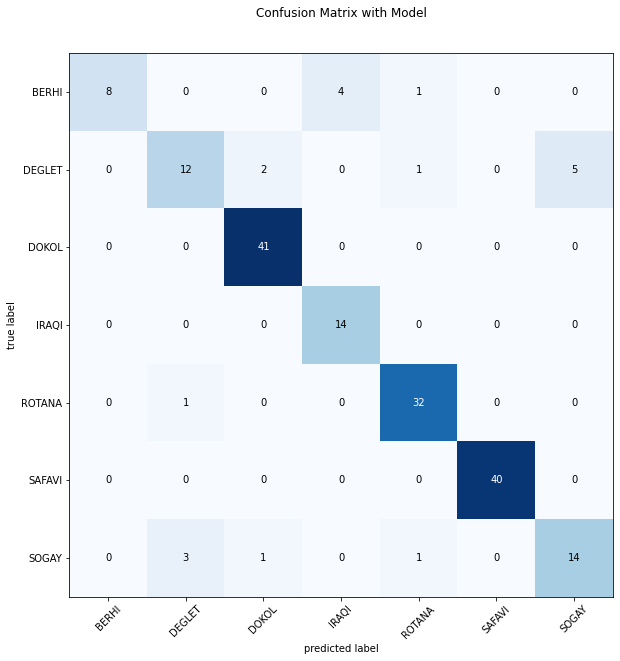

In [18]:
result=confusion_matrix(Y_test,grid_preds_lgbm)
fig,ax=plt.subplots(figsize=(10,10))
plot_confusion_matrix(conf_mat=result,figsize=(18,10),class_names=np.unique(Y_test),axis=ax)

ax.set_title('Confusion Matrix with Model\n\n');
fig.show()

# 9.Pipeline with KNN
## 9.1 Pipeline

In [19]:
pipeline_knn=Pipeline(steps=[
    ('transformer',col_transformer),
    ('model',KNeighborsClassifier(n_neighbors=5,
                                  leaf_size=30,
                                  p=2))
])

## 9.2 Grid Search 

In [20]:
param_grid_knn = {
    'model__n_neighbors':[5,10,2,3,4],
    'model__leaf_size':[5,15,2,3,4],
    'model__p':[1,2],
    'model__weights':['uniform','distance']
}

grid_search_knn = GridSearchCV(pipeline_knn, param_grid_knn, cv=5, scoring='accuracy',error_score='raise')
# and now we train over all the possible combinations of the parameters above
grid_search_knn.fit(X_train,Y_train.values.ravel())

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scale',
                                                                                          StandardScaler())]),
                                                                         Index(['AREA', 'PERIMETER', 'MAJOR_AXIS', 'MINOR_AXIS', 'ECCENTRICITY',
       'EQDIASQ', 'SOLIDITY', 'CONVEX_AREA', 'EXTENT', 'ASPECT_RATIO',
       'ROUNDNESS', 'COMPACTNESS', 'SHAPEFACTOR_1', 'SHAPEFACTOR_2',
       'SH...
       'StdDevRR', 'StdDevRG', 'StdDevRB', 'SkewRR', 'SkewRG', 'SkewRB',
       'KurtosisRR', 'KurtosisRG', 'KurtosisRB', 'EntropyRR', 'EntropyRG',
       'EntropyRB', 'ALLdaub4RR', 'ALLdaub4RG', 'ALLdaub4RB'],
      dtype='object'))])),
                                       ('model', KNeighborsClassifier())]),
  

## 9.3 Model Evaluation

In [21]:
grid_preds_knn=grid_search_knn.predict(X_test)
grid_search_knn.best_params_

{'model__leaf_size': 5,
 'model__n_neighbors': 5,
 'model__p': 1,
 'model__weights': 'distance'}

In [22]:
print(classification_report(Y_test,grid_preds_knn))

              precision    recall  f1-score   support

       BERHI       1.00      0.77      0.87        13
      DEGLET       0.72      0.65      0.68        20
       DOKOL       0.93      1.00      0.96        41
       IRAQI       0.88      1.00      0.93        14
      ROTANA       0.94      0.97      0.96        33
      SAFAVI       1.00      1.00      1.00        40
       SOGAY       0.78      0.74      0.76        19

    accuracy                           0.91       180
   macro avg       0.89      0.88      0.88       180
weighted avg       0.91      0.91      0.91       180



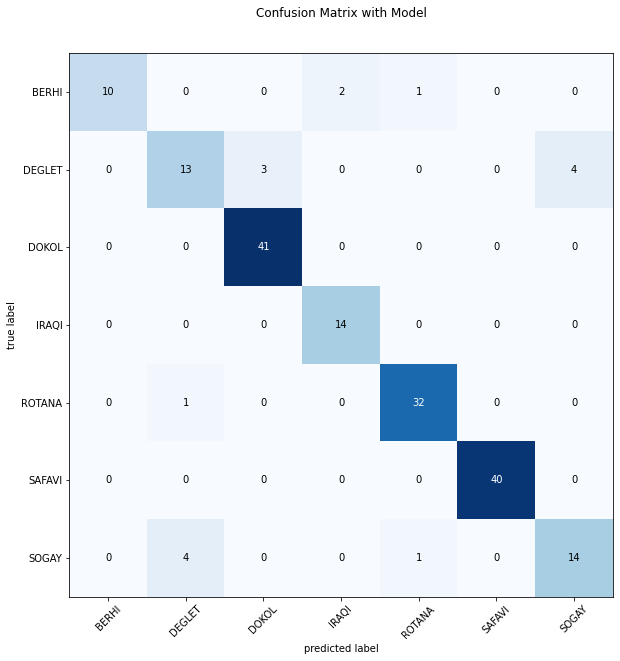

In [23]:
result=confusion_matrix(Y_test,grid_preds_knn)
fig,ax=plt.subplots(figsize=(10,10))
plot_confusion_matrix(conf_mat=result,figsize=(18,10),class_names=np.unique(Y_test),axis=ax)

ax.set_title('Confusion Matrix with Model\n\n');
fig.show()